# VARMAX Model Building
---
Vector Auto Regression Moving Average eXogenous

In [2]:
# Import general dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Ml modeling dependencies
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

# sklearn metrics for root mean squared error (rmse)
from sklearn.metrics import mean_squared_error

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

## Functions
---

In [3]:
def plot_feature(df, nrows = 1, ncols = 1):
    '''Function to plot the features in a dataframe with time being the index value'''
    fig_ff, axes_ff = plt.subplots(nrows = nrows, ncols = ncols, dpi = 120)
    
    for i, ax in enumerate(axes_ff.flatten()):
        data = df[df.columns[i]]

        ax.plot(data, color = 'red', linewidth = 1)
        ax.set_title(ff_df.columns[i])
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines['top'].set_alpha(0)
        ax.tick_params(labelsize = 6)

    plt.tight_layout()

def print_ADF(df):
    '''Function to verify which features in the DF is stationary or nonstationary by using the ADF test'''
    cols = list(df)
    ideal_features = []
    
    for col in cols:
        try:
            ad_fuller_result = adfuller(df[col])

            print(f'real {col}')        

            if ad_fuller_result[1] < 0.05:
                print(f'ADF Statistic: {ad_fuller_result[0]}')
                print(f'p-value: {ad_fuller_result[1]}')
                ideal_features.append(col)
            else:
                print(f'p-value: {ad_fuller_result[1]} ==> Non-stationary')
        except:
            print(col) 
            print('Failed to run the ADF test')
        print('-' * 10)
    
    print('Stationary features:', ideal_features)

def get_var_lag_summary(train_df, maxlags = 10):
    '''Function to print the summary for select_order with recommended # of lag based on lowest AIC'''
    model = VAR(train_df.diff()[1 : ])
    sorted_order = model.select_order(maxlags = maxlags)
    print(sorted_order.summary())
    
def get_rt_mean_sqr_err(pred_df, test_df):
    '''Function that simply prints the  rmse and the percent difference'''
    rmse = np.sqrt(mean_squared_error(pred_df, test_df))
    
    print(f'{pred_df.columns[0]}\'s Root Mean Squared Error (RMSE) is: {rmse}')
    print('The mean of the test data', test_df.mean())
    print('Percent error:', rmse / test_df.mean())

## Load Cleaned Data
---
Load the data from the SQLite database then create a dataframe for each of the energy source.

In [4]:
# Load the table epo from sqlite database
db = '../static/data/eia_electric.sqlite'
engine = create_engine(f'sqlite:///{db}')
conn = engine.connect()

In [5]:
# Read into DataFrame and set the period as index while parsing it as datetime format then display the dataframe
data = pd.read_sql('SELECT * FROM epo', conn, parse_dates = ['period'])
data.head()

,period,energySource,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
0,2008-01-01,fossil fuels,3.12,281.61,10.36,7.00,28830.19,9.85,266757.42,23911.23,0.82,291.97
1,2008-01-01,others,0.00,251.47,0.88,0.00,23851.43,0.00,0.00,0.00,0.00,252.35
2,2008-01-01,renewables,2.65,14.39,4.72,1.06,1313.12,1.05,466.37,77.00,0.09,19.11
3,2008-02-01,fossil fuels,3.03,193.27,8.91,6.69,19511.71,11.03,191351.71,17899.89,1.16,202.18
4,2008-02-01,others,0.00,2.76,0.69,0.00,200.83,0.00,0.00,0.00,0.00,3.46


In [6]:
data.tail()

,period,energySource,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
534,2022-11-01,others,0.00,130.83,0.08,0.00,12466.51,5.98,0.00,0.00,0.00,130.91
535,2022-11-01,renewables,0.17,13.43,1.66,0.05,3578.77,1.24,2.28,8.30,0.00,15.09
536,2022-12-01,fossil fuels,3.21,183.83,6.85,5.94,20905.52,9.56,172004.56,12712.98,0.90,190.68
537,2022-12-01,others,0.00,180.32,0.44,0.00,17167.95,4.70,0.00,0.00,0.00,180.76
538,2022-12-01,renewables,1.18,19.61,2.91,0.05,5090.05,1.54,173.80,28.31,0.05,22.52


In [7]:
# Close out of the engine
engine.dispose()

In [8]:
# Check the dataframe using .info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   period                  539 non-null    datetime64[ns]
 1   energySource            539 non-null    object        
 2   ash-content             539 non-null    float64       
 3   consumption-for-eg-btu  539 non-null    float64       
 4   consumption-uto-btu     539 non-null    float64       
 5   cost-per-btu            539 non-null    float64       
 6   generation              539 non-null    float64       
 7   heat-content            539 non-null    float64       
 8   receipts-btu            539 non-null    float64       
 9   stocks                  539 non-null    float64       
 10  sulfur-content          539 non-null    float64       
 11  total-consumption-btu   539 non-null    float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memor

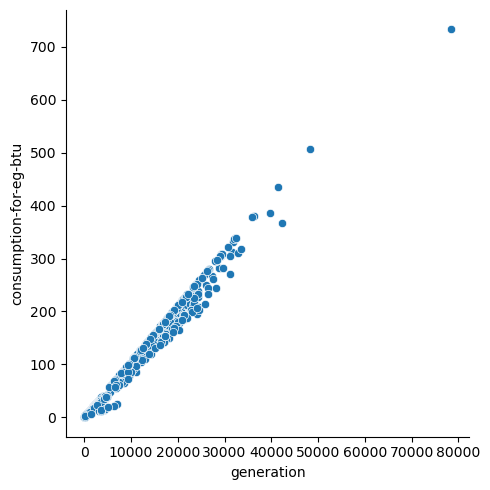

In [9]:
# Look at the relation between consumption-for-eg-btu and generation
sns.relplot(x = data['generation'], y = data['consumption-for-eg-btu'], data = data)

In [10]:
# Split the data frame based on the energy source and set index on the period
ff_df = data.loc[data['energySource'] == 'fossil fuels'].drop(columns = ['energySource']).set_index('period')
re_df = data.loc[data['energySource'] == 'renewables'].drop(columns = ['energySource']).set_index('period')
oth_df = data.loc[data['energySource'] == 'others'].drop(columns = ['energySource']).set_index('period')

In [10]:
# Check the shape
# Note: other energy sources is missing an observation for the time series of 2021-02
print(ff_df.shape, re_df.shape, oth_df.shape)

(180, 10) (180, 10) (179, 10)


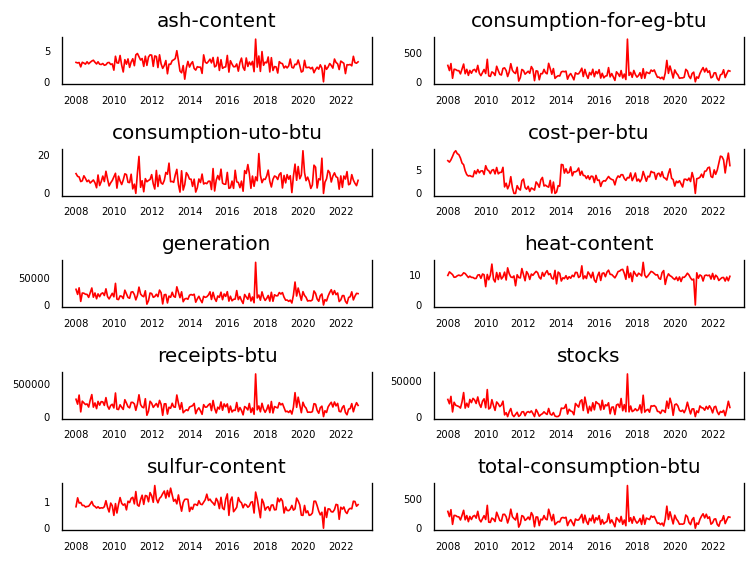

In [12]:
# Plot the features for intial correlation observation for the ff_df
plot_feature(ff_df, 5, 2)

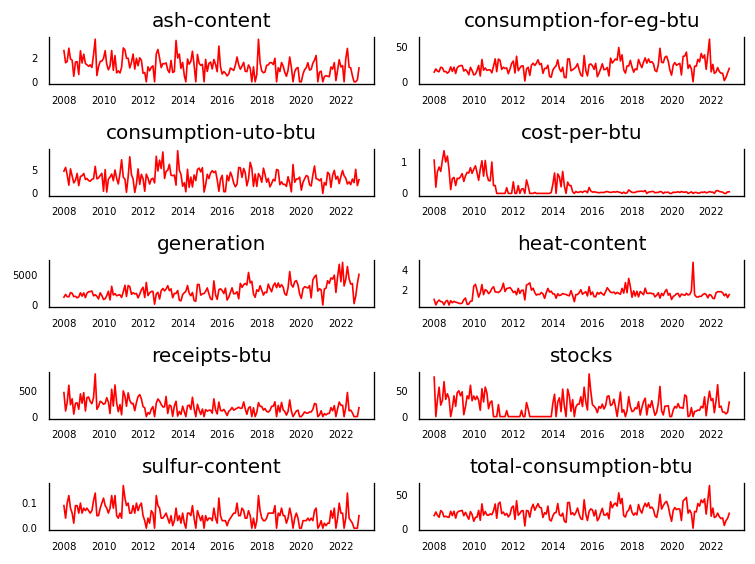

In [13]:
# Plot the features for intial correlation observation for the re_df
plot_feature(re_df, 5, 2)

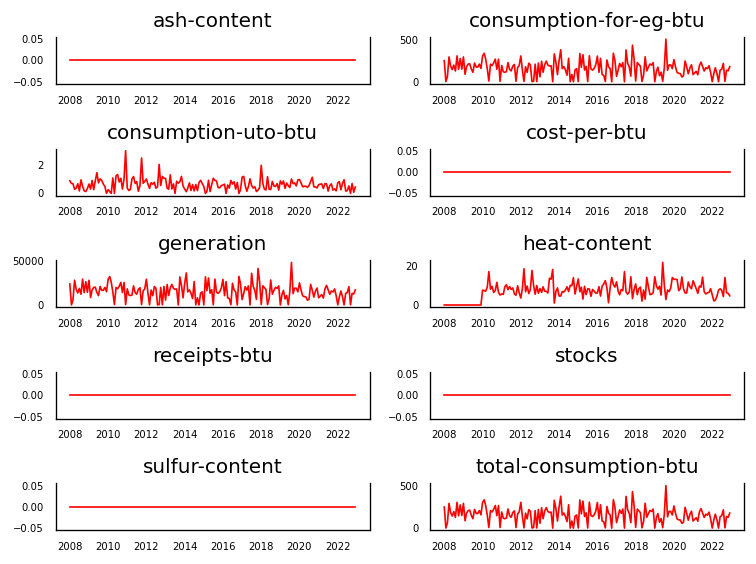

In [14]:
# Plot the features for intial correlation observation for the oth_df
plot_feature(oth_df, 5, 2)

## Augmented Dickey-Fuller (ADF) Test
---
Use ADF test to determine which features are stationary where the observations are unaffected by time (where `p-value` should be less than or equal to `0.05` which nullify the null hypothese where the data is non-stationary. This helps to determine which features to use. `diff([1:])` will be used to calculate the differences between observations to help make the data more stationary by removing the trends or removing the series dependencies on time.

From the outputs below, we will be using `'consumption-for-eg-btu'` and `'generation'`

The Null hypothesis here is: The data is non-stationary.

In [15]:
# ADF - Augmented Dickey-Fuller test for ff_df
print_ADF(ff_df)

real ash-content
ADF Statistic: -3.7957385495201574
p-value: 0.002951217374140209
----------
real consumption-for-eg-btu
ADF Statistic: -13.64654955066991
p-value: 1.6155237015266724e-25
----------
real consumption-uto-btu
ADF Statistic: -13.922564596566515
p-value: 5.263143601947581e-26
----------
real cost-per-btu
p-value: 0.06186929400102758 ==> Non-stationary
----------
real generation
ADF Statistic: -13.899101306423555
p-value: 5.778287580900149e-26
----------
real heat-content
ADF Statistic: -6.234560577534986
p-value: 4.861064644047856e-08
----------
real receipts-btu
ADF Statistic: -13.618731936581332
p-value: 1.8138415629131716e-25
----------
real stocks
ADF Statistic: -4.530713517338306
p-value: 0.0001729826237795199
----------
real sulfur-content
ADF Statistic: -3.4282007387469164
p-value: 0.010034264474000748
----------
real total-consumption-btu
ADF Statistic: -13.773619347970351
p-value: 9.580304525848666e-26
----------
Stationary features: ['ash-content', 'consumption-fo

In [16]:
# ADF - Augmented Dickey-Fuller test for re_df
print_ADF(re_df)

real ash-content
ADF Statistic: -10.948224478006571
p-value: 8.934011091860279e-20
----------
real consumption-for-eg-btu
ADF Statistic: -9.768847886810988
p-value: 7.226606430085845e-17
----------
real consumption-uto-btu
ADF Statistic: -12.201686893088409
p-value: 1.2191365674751165e-22
----------
real cost-per-btu
p-value: 0.1624183995797907 ==> Non-stationary
----------
real generation
ADF Statistic: -4.417748487881834
p-value: 0.00027608460826115364
----------
real heat-content
ADF Statistic: -5.550226529862903
p-value: 1.6261310063840765e-06
----------
real receipts-btu
ADF Statistic: -3.266369658130199
p-value: 0.01645033035014304
----------
real stocks
ADF Statistic: -3.143556218179818
p-value: 0.023493296062644806
----------
real sulfur-content
ADF Statistic: -3.4564510405738904
p-value: 0.009178548425067965
----------
real total-consumption-btu
ADF Statistic: -9.968360827337982
p-value: 2.2750065888513646e-17
----------
Stationary features: ['ash-content', 'consumption-for-eg

In [17]:
# ADF - Augmented Dickey-Fuller test for oth_df
print_ADF(oth_df)

ash-content
Failed to run the ADF test
----------
real consumption-for-eg-btu
ADF Statistic: -14.565627872722498
p-value: 4.717152849772396e-27
----------
real consumption-uto-btu
ADF Statistic: -12.558857797160021
p-value: 2.1244474065451822e-23
----------
cost-per-btu
Failed to run the ADF test
----------
real generation
ADF Statistic: -14.562497541599194
p-value: 4.769501329164546e-27
----------
real heat-content
ADF Statistic: -3.1350062235202207
p-value: 0.02406871805114095
----------
receipts-btu
Failed to run the ADF test
----------
stocks
Failed to run the ADF test
----------
sulfur-content
Failed to run the ADF test
----------
real total-consumption-btu
ADF Statistic: -14.56733281138573
p-value: 4.688897210370675e-27
----------
Stationary features: ['consumption-for-eg-btu', 'consumption-uto-btu', 'generation', 'heat-content', 'total-consumption-btu']


## Granger Causality Test
---
Use the Granger Causality test to verify the correlation between `'consumption-for-eg-btu'` and `'generation'` and see if 'consumption-for-eg-btu' does in fact causes 'generation' based on the best lag time with lowest `p-score`.

**Note:** The granger causality test for energy source `others` have the least favorable p-score out of the other energy source. The lowest p-score found was at around lag # 36.

Granger Causality: `Others (consumption-for-eg-btu causes generation)`\
number of lags (no zero) 36\
ssr based F test:         F=1.4895  , p=0.0773  , df_denom=70, df_num=36\
ssr based chi2 test:   chi2=109.5407, p=0.0000  , df=36\
likelihood ratio test: chi2=81.3281 , p=0.0000  , df=36\
parameter F test:         F=1.4895  , p=0.0773  , df_denom=70, df_num=36\

In [18]:
# For ff_df which is observed at lag #9
gc_ff_cons_gen = grangercausalitytests(ff_df[['consumption-for-eg-btu', 'generation']], 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0671  , p=0.1523  , df_denom=176, df_num=1
ssr based chi2 test:   chi2=2.1023  , p=0.1471  , df=1
likelihood ratio test: chi2=2.0901  , p=0.1483  , df=1
parameter F test:         F=2.0671  , p=0.1523  , df_denom=176, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9661  , p=0.0541  , df_denom=173, df_num=2
ssr based chi2 test:   chi2=6.1037  , p=0.0473  , df=2
likelihood ratio test: chi2=6.0014  , p=0.0498  , df=2
parameter F test:         F=2.9661  , p=0.0541  , df_denom=173, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1588  , p=0.0947  , df_denom=170, df_num=3
ssr based chi2 test:   chi2=6.7431  , p=0.0806  , df=3
likelihood ratio test: chi2=6.6178  , p=0.0851  , df=3
parameter F test:         F=2.1588  , p=0.0947  , df_denom=170, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9623  , p=0.1026  

In [19]:
# For re_df which is observed at lag #11
gc_re_cons_gen = grangercausalitytests(re_df[['consumption-for-eg-btu', 'generation']], 15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4266  , p=0.5145  , df_denom=176, df_num=1
ssr based chi2 test:   chi2=0.4339  , p=0.5101  , df=1
likelihood ratio test: chi2=0.4334  , p=0.5103  , df=1
parameter F test:         F=0.4266  , p=0.5145  , df_denom=176, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8738  , p=0.4192  , df_denom=173, df_num=2
ssr based chi2 test:   chi2=1.7981  , p=0.4069  , df=2
likelihood ratio test: chi2=1.7891  , p=0.4088  , df=2
parameter F test:         F=0.8738  , p=0.4192  , df_denom=173, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7950  , p=0.4982  , df_denom=170, df_num=3
ssr based chi2 test:   chi2=2.4832  , p=0.4783  , df=3
likelihood ratio test: chi2=2.4659  , p=0.4815  , df=3
parameter F test:         F=0.7950  , p=0.4982  , df_denom=170, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7557  , p=0.5556  

In [20]:
# For oth_df
gc_oth_cons_gen = grangercausalitytests(oth_df[['consumption-for-eg-btu', 'generation']], 50)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3515  , p=0.5540  , df_denom=175, df_num=1
ssr based chi2 test:   chi2=0.3576  , p=0.5499  , df=1
likelihood ratio test: chi2=0.3572  , p=0.5501  , df=1
parameter F test:         F=0.3515  , p=0.5540  , df_denom=175, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2987  , p=0.1035  , df_denom=172, df_num=2
ssr based chi2 test:   chi2=4.7311  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6689  , p=0.0969  , df=2
parameter F test:         F=2.2987  , p=0.1035  , df_denom=172, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0257  , p=0.1122  , df_denom=169, df_num=3
ssr based chi2 test:   chi2=6.3289  , p=0.0967  , df=3
likelihood ratio test: chi2=6.2177  , p=0.1015  , df=3
parameter F test:         F=2.0257  , p=0.1122  , df_denom=169, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4073  , p=0.2337  

ssr based F test:         F=1.3522  , p=0.1568  , df_denom=46, df_num=44
ssr based chi2 test:   chi2=174.6051, p=0.0000  , df=44
likelihood ratio test: chi2=112.0531, p=0.0000  , df=44
parameter F test:         F=1.3522  , p=0.1568  , df_denom=46, df_num=44

Granger Causality
number of lags (no zero) 45
ssr based F test:         F=1.2813  , p=0.2081  , df_denom=43, df_num=45
ssr based chi2 test:   chi2=179.6792, p=0.0000  , df=45
likelihood ratio test: chi2=113.9711, p=0.0000  , df=45
parameter F test:         F=1.2813  , p=0.2081  , df_denom=43, df_num=45

Granger Causality
number of lags (no zero) 46
ssr based F test:         F=1.2992  , p=0.2004  , df_denom=40, df_num=46
ssr based chi2 test:   chi2=198.7053, p=0.0000  , df=46
likelihood ratio test: chi2=121.5484, p=0.0000  , df=46
parameter F test:         F=1.2992  , p=0.2004  , df_denom=40, df_num=46

Granger Causality
number of lags (no zero) 47
ssr based F test:         F=1.3673  , p=0.1635  , df_denom=37, df_num=47
ssr based ch

## Training Model 1
---
Split the models into training and data set at about 75/25 percent, leaving it with 132 months total for training and 48 months for testing. The reason for this ratio split is to keep the full years instead of random months.

In [11]:
# For fossil fuels
train_ff = ff_df[['consumption-for-eg-btu', 'generation']][: 132]
test_ff = ff_df[['consumption-for-eg-btu', 'generation']][132: ]

# For renewable fuels
train_re = re_df[['consumption-for-eg-btu', 'generation']][: 132]
test_re = re_df[['consumption-for-eg-btu', 'generation']][132: ]

# For other fuels
train_oth = oth_df[['consumption-for-eg-btu', 'generation']][: 132]
test_oth = oth_df[['consumption-for-eg-btu', 'generation']][132: ]

In [12]:
# Get the shapes
print('Fossile Fuels', train_ff.shape, test_ff.shape)
print('Reneables', train_re.shape, test_re.shape)
print('Other FUels', train_oth.shape, test_oth.shape)

Fossile Fuels (132, 2) (48, 2)
Reneables (132, 2) (48, 2)
Other FUels (132, 2) (47, 2)


Determine the lags needed for each of the energy source by using the VAR model's select_order. `diff()[1: ]` is also being used here to help make the data stationary similar to what we did with the ADF above. We want to look for the best/lowest AIC possible in which VAR model provides with the highlight from the `select_order()` function.

With below output, we will be using the lag 40 for all 3 energy sources.

In [45]:
# For fossil fuels
get_var_lag_summary(train_ff, maxlags = 40)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        23.48       23.54   1.580e+10       23.51
1        22.84       23.01   8.329e+09       22.91
2        22.61       22.88   6.570e+09       22.72
3        22.48      22.87*  5.810e+09*      22.64*
4        22.51       23.01   5.995e+09       22.71
5        22.49       23.09   5.839e+09       22.73
6        22.52       23.24   6.084e+09       22.81
7        22.54       23.37   6.178e+09       22.87
8        22.61       23.55   6.656e+09       22.99
9        22.56       23.61   6.361e+09       22.98
10       22.55       23.71   6.296e+09       23.01
11       22.52       23.79   6.172e+09       23.03
12       22.57       23.95   6.500e+09       23.12
13       22.63       24.12   6.949e+09       23.23
14       22.66       24.26   7.263e+09       23.31
15       22.67       24.38   7.434e+09       23.36
16       22.71       24.53   7.

In [46]:
# For renewables fuels
get_var_lag_summary(train_re, maxlags = 40)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        14.27       14.32   1.573e+06       14.29
1        14.00       14.16   1.200e+06       14.06
2        13.73      14.01*   9.209e+05       13.84
3        13.64       14.02   8.366e+05      13.79*
4        13.71       14.20   8.972e+05       13.91
5        13.76       14.36   9.451e+05       14.00
6        13.70       14.42   8.947e+05       13.99
7        13.68       14.51   8.787e+05       14.01
8        13.64       14.58   8.449e+05       14.02
9        13.52       14.57  7.559e+05*       13.95
10       13.56       14.72   7.901e+05       14.03
11       13.64       14.91   8.608e+05       14.16
12       13.64       15.02   8.664e+05       14.20
13       13.65       15.14   8.771e+05       14.25
14       13.65       15.25   8.890e+05       14.30
15       13.71       15.42   9.533e+05       14.40
16       13.75       15.57   1.

In [47]:
# For other fuels
get_var_lag_summary(train_oth, maxlags = 40)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        19.01       19.07   1.809e+08       19.04
1        18.44       18.61   1.020e+08       18.51
2        18.03       18.30   6.741e+07       18.14
3        17.81      18.20*   5.452e+07       17.97
4        17.77       18.26  5.209e+07*      17.97*
5        17.84       18.45   5.628e+07       18.09
6        17.83       18.55   5.558e+07       18.12
7        17.90       18.73   5.965e+07       18.23
8        17.95       18.89   6.311e+07       18.33
9        17.97       19.02   6.473e+07       18.40
10       17.99       19.15   6.614e+07       18.46
11       18.04       19.31   7.001e+07       18.55
12       17.92       19.30   6.266e+07       18.48
13       17.98       19.47   6.691e+07       18.58
14       17.99       19.59   6.807e+07       18.64
15       18.03       19.75   7.195e+07       18.72
16       18.08       19.90   7.

Fit the models to VARMAX instance and use the best lag based on the `VAR` suggested order with max iteration of 200.

**Note:** We did not utilize the `diff()` function to make the data stationary when splitting the data since we will enforce the stationary when we instantiate the VARMAX instance.

### Fossil fuels

In [48]:
var_ff_model = VARMAX(train_ff, order = (40, 0), enforce_stationarity  = True)
fit_var_ff_model = var_ff_model.fit(maxiter = 200, disp = False)
print(fit_var_ff_model.summary())

                                      Statespace Model Results                                      
Dep. Variable:     ['consumption-for-eg-btu', 'generation']   No. Observations:                  132
Model:                                              VAR(40)   Log Likelihood               -1770.444
                                                + intercept   AIC                           3870.887
Date:                                      Sun, 11 Feb 2024   BIC                           4346.550
Time:                                              22:02:51   HQIC                          4064.175
Sample:                                          01-01-2008                                         
                                               - 12-01-2018                                         
Covariance Type:                                        opg                                         
Ljung-Box (L1) (Q):             0.50, 0.08   Jarque-Bera (JB):         229.71, 8.64
Prob(Q)

In [49]:
# Get the number of n_forecast
ff_n_forecast = len(test_ff)
ff_n_forecast

48

In [50]:

ff_predict = fit_var_ff_model.get_prediction(start = len(train_ff), end = len(train_ff) + ff_n_forecast - 1)
ff_predictions = ff_predict.predicted_mean

In [51]:
# Create the columns for the predicted data
ff_predictions.columns = ['consumption-for-eg-btu_pred', 'generation_pred']
ff_predictions.head()

,consumption-for-eg-btu_pred,generation_pred
2019-01-01,211.370547,22660.960912
2019-02-01,187.462622,20271.304770
2019-03-01,211.881339,23328.851374
2019-04-01,142.956336,15068.799489
2019-05-01,163.757490,18715.191042


In [52]:
# Get the Root Mean Squared Error (SMSE) for each of the columns
# For consumption
get_rt_mean_sqr_err(ff_predictions[['consumption-for-eg-btu_pred']], test_ff[['consumption-for-eg-btu']])

print()

# For generation
get_rt_mean_sqr_err(ff_predictions[['generation_pred']], test_ff[['generation']])

consumption-for-eg-btu_pred's Root Mean Squared Error (RMSE) is: 79.55995119240922
The mean of the test data consumption-for-eg-btu    131.4925
dtype: float64
Percent error: consumption-for-eg-btu    0.605053
dtype: float64

generation_pred's Root Mean Squared Error (RMSE) is: 8694.727474694171
The mean of the test data generation    15228.362708
dtype: float64
Percent error: generation    0.570956
dtype: float64


In [53]:
# Concat the predicted columns to the test columns for consumption
ff_test_vs_pred_cons = pd.concat([test_ff['consumption-for-eg-btu'], ff_predictions['consumption-for-eg-btu_pred']], axis = 1)
ff_test_vs_pred_cons.head()

,consumption-for-eg-btu,consumption-for-eg-btu_pred
2019-01-01,135.74,211.370547
2019-02-01,77.35,187.462622
2019-03-01,81.59,211.881339
2019-04-01,55.30,142.956336
2019-05-01,79.33,163.757490


<Axes: >

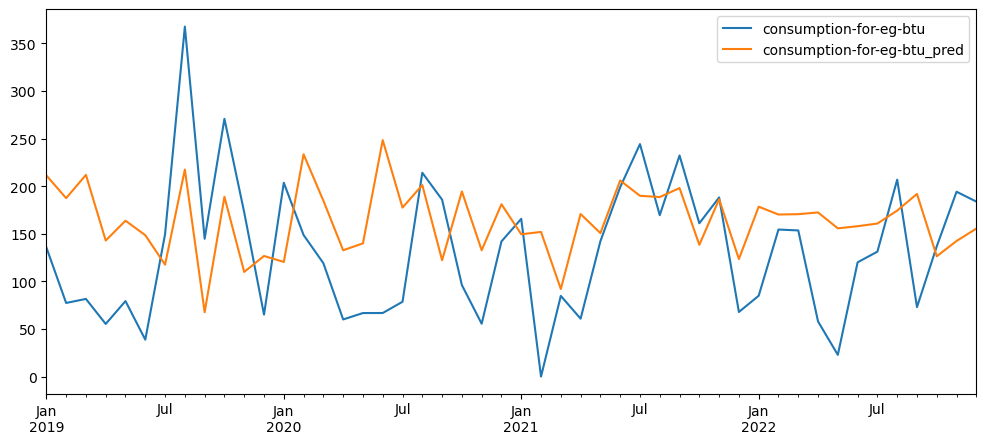

In [54]:
# Plot the chart
ff_test_vs_pred_cons.plot(figsize = (12, 5))

In [55]:
# Concat the predicted columns to the test columns for generation
ff_test_vs_pred_gen = pd.concat([test_ff['generation'], ff_predictions['generation_pred']], axis = 1)
ff_test_vs_pred_gen.head()

,generation,generation_pred
2019-01-01,14308.32,22660.960912
2019-02-01,8818.93,20271.304770
2019-03-01,9225.17,23328.851374
2019-04-01,6699.21,15068.799489
2019-05-01,8960.60,18715.191042


<Axes: >

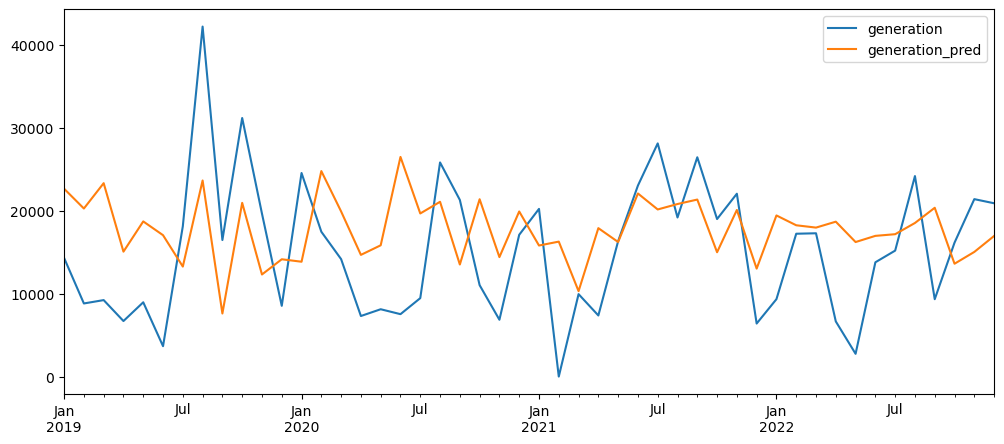

In [56]:
# Plot the chart
ff_test_vs_pred_gen.plot(figsize = (12, 5))

In [57]:
# Export the predicted data into Json format
pd.concat([test_ff, ff_predictions], axis = 1).reset_index().rename(columns = {'index': 'period'}).to_json('../static/data/predicted_ff_1.json', orient = 'records', date_format = 'iso')

### Renewable Fuels

In [13]:
var_re_model = VARMAX(train_re, order = (40, 0), enforce_stationarity  = True)
fit_var_re_model = var_re_model.fit(maxiter = 200, disp = False)
print(fit_var_re_model.summary())

                                      Statespace Model Results                                      
Dep. Variable:     ['consumption-for-eg-btu', 'generation']   No. Observations:                  132
Model:                                              VAR(40)   Log Likelihood               -1171.371
                                                + intercept   AIC                           2672.743
Date:                                      Sun, 11 Feb 2024   BIC                           3148.405
Time:                                              22:56:24   HQIC                          2866.030
Sample:                                          01-01-2008                                         
                                               - 12-01-2018                                         
Covariance Type:                                        opg                                         
Ljung-Box (L1) (Q):             0.01, 0.52   Jarque-Bera (JB):          1.09, 20.38
Prob(Q)

In [14]:
# Get the number of n_forecast
re_n_forecast = len(test_re)
re_n_forecast

48

In [15]:
# Fit the model
re_predict = fit_var_re_model.get_prediction(start = len(train_re), end = len(train_re) + re_n_forecast - 1)
re_predictions = re_predict.predicted_mean

In [16]:
# Create the columns for the predicted data
re_predictions.columns = ['consumption-for-eg-btu_pred', 'generation_pred']
re_predictions.head()

,consumption-for-eg-btu_pred,generation_pred
2019-01-01,30.215794,3155.113570
2019-02-01,31.950297,3396.257152
2019-03-01,10.089637,1179.344458
2019-04-01,34.835817,3619.741125
2019-05-01,20.399124,2127.130966


In [17]:
# Get the Root Mean Squared Error (SMSE) for each of the columns
# For consumption
get_rt_mean_sqr_err(re_predictions[['consumption-for-eg-btu_pred']], test_re[['consumption-for-eg-btu']])

print()

# For generation
get_rt_mean_sqr_err(re_predictions[['generation_pred']], test_re[['generation']])

consumption-for-eg-btu_pred's Root Mean Squared Error (RMSE) is: 12.543671207596576
The mean of the test data consumption-for-eg-btu    24.50875
dtype: float64
Percent error: consumption-for-eg-btu    0.511804
dtype: float64

generation_pred's Root Mean Squared Error (RMSE) is: 1930.984660826509
The mean of the test data generation    3400.493333
dtype: float64
Percent error: generation    0.567854
dtype: float64


In [18]:
# Concat the predicted columns to the test columns for consumption
re_test_vs_pred_cons = pd.concat([test_re['consumption-for-eg-btu'], re_predictions['consumption-for-eg-btu_pred']], axis = 1)
re_test_vs_pred_cons.head()

,consumption-for-eg-btu,consumption-for-eg-btu_pred
2019-01-01,29.20,30.215794
2019-02-01,26.14,31.950297
2019-03-01,16.80,10.089637
2019-04-01,14.94,34.835817
2019-05-01,24.52,20.399124


<Axes: >

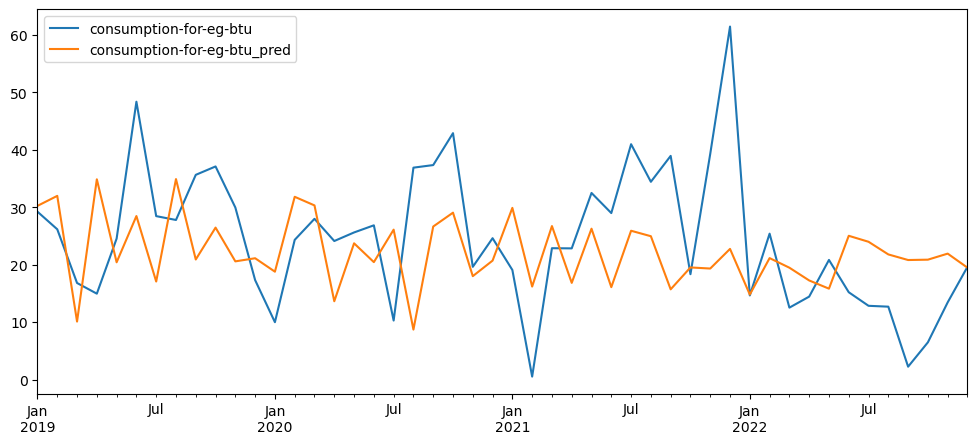

In [19]:
# Plot the chart
re_test_vs_pred_cons.plot(figsize = (12, 5))

In [20]:
# Concat the predicted columns to the test columns for generation
re_test_vs_pred_gen = pd.concat([test_re['generation'], re_predictions['generation_pred']], axis = 1)
re_test_vs_pred_gen.head()

,generation,generation_pred
2019-01-01,3384.11,3155.113570
2019-02-01,2949.20,3396.257152
2019-03-01,1886.52,1179.344458
2019-04-01,1629.14,3619.741125
2019-05-01,2844.62,2127.130966


<Axes: >

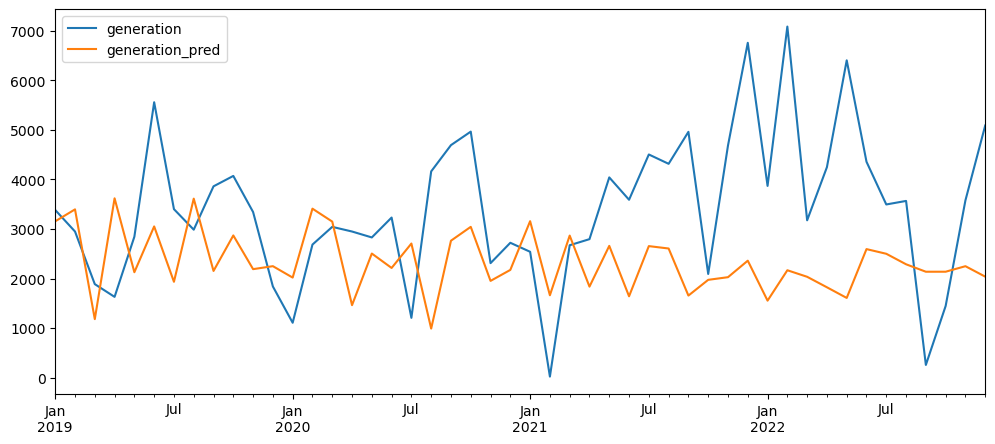

In [21]:
# Plot the chart
re_test_vs_pred_gen.plot(figsize = (12, 5))

In [22]:
# Export the predicted data into Json format
pd.concat([test_re, re_predictions], axis = 1).reset_index().rename(columns = {'index': 'period'}).to_json('../static/data/predicted_renewables.json', orient = 'records', date_format = 'iso')

### Other Fuels
---
***NOTE:*** There is a missing month within the original dataset for the month of 2021-02

In [23]:
var_oth_model = VARMAX(train_oth, order = (40, 0), enforce_stationarity  = True)
fit_var_oth_model = var_oth_model.fit(maxiter = 200, disp = False)
print(fit_var_oth_model.summary())

                                      Statespace Model Results                                      
Dep. Variable:     ['consumption-for-eg-btu', 'generation']   No. Observations:                  132
Model:                                              VAR(40)   Log Likelihood               -1464.374
                                                + intercept   AIC                           3258.749
Date:                                      Sun, 11 Feb 2024   BIC                           3734.411
Time:                                              22:59:28   HQIC                          3452.036
Sample:                                          01-01-2008                                         
                                               - 12-01-2018                                         
Covariance Type:                                        opg                                         
Ljung-Box (L1) (Q):             0.11, 0.11   Jarque-Bera (JB):          1.33, 38.21
Prob(Q)

In [24]:
# Get the number of n_forecast
oth_n_forecast = len(test_oth)
oth_n_forecast

47

In [25]:
# Fit the model
oth_predict = fit_var_oth_model.get_prediction(start = len(train_oth), end = len(train_oth) + oth_n_forecast - 1)
oth_predictions = oth_predict.predicted_mean

In [26]:
# Create the columns for the predicted data
oth_predictions.columns = ['consumption-for-eg-btu_pred', 'generation_pred']
oth_predictions.head()

,consumption-for-eg-btu_pred,generation_pred
2019-01-01,36.921435,3428.106683
2019-02-01,201.240542,19243.401176
2019-03-01,228.000558,21610.709681
2019-04-01,149.378661,14127.802244
2019-05-01,162.077265,15458.913124


In [27]:
# Get the Root Mean Squared Error (SMSE) for each of the columns
# For consumption
get_rt_mean_sqr_err(oth_predictions[['consumption-for-eg-btu_pred']], test_oth[['consumption-for-eg-btu']])

print()

# For generation
get_rt_mean_sqr_err(oth_predictions[['generation_pred']], test_oth[['generation']])

consumption-for-eg-btu_pred's Root Mean Squared Error (RMSE) is: 91.4641685736711
The mean of the test data consumption-for-eg-btu    140.584468
dtype: float64
Percent error: consumption-for-eg-btu    0.650599
dtype: float64

generation_pred's Root Mean Squared Error (RMSE) is: 8728.927442248634
The mean of the test data generation    13356.199149
dtype: float64
Percent error: generation    0.653549
dtype: float64


In [28]:
# Concat the predicted columns to the test columns for consumption
oth_test_vs_pred_cons = pd.concat([test_oth['consumption-for-eg-btu'], oth_predictions['consumption-for-eg-btu_pred']], axis = 1)
oth_test_vs_pred_cons.head()

,consumption-for-eg-btu,consumption-for-eg-btu_pred
2019-01-01,1.04,36.921435
2019-02-01,126.33,201.240542
2019-03-01,173.64,228.000558
2019-04-01,72.35,149.378661
2019-05-01,114.85,162.077265


<Axes: >

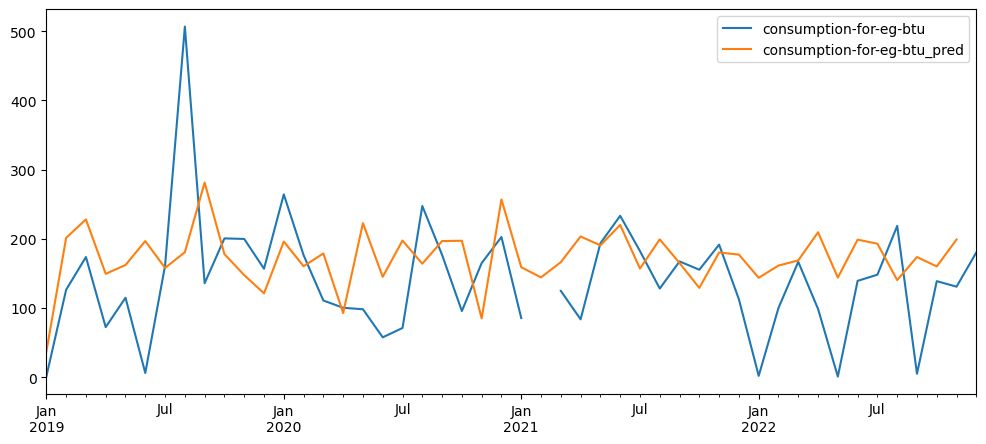

In [29]:
# Plot the chart
oth_test_vs_pred_cons.plot(figsize = (12, 5))

In [30]:
# Concat the predicted columns to the test columns for generation
oth_test_vs_pred_gen = pd.concat([test_oth['generation'], oth_predictions['generation_pred']], axis = 1)
oth_test_vs_pred_gen.head()

,generation,generation_pred
2019-01-01,56.93,3428.106683
2019-02-01,11995.09,19243.401176
2019-03-01,16532.69,21610.709681
2019-04-01,6874.90,14127.802244
2019-05-01,10873.03,15458.913124


<Axes: >

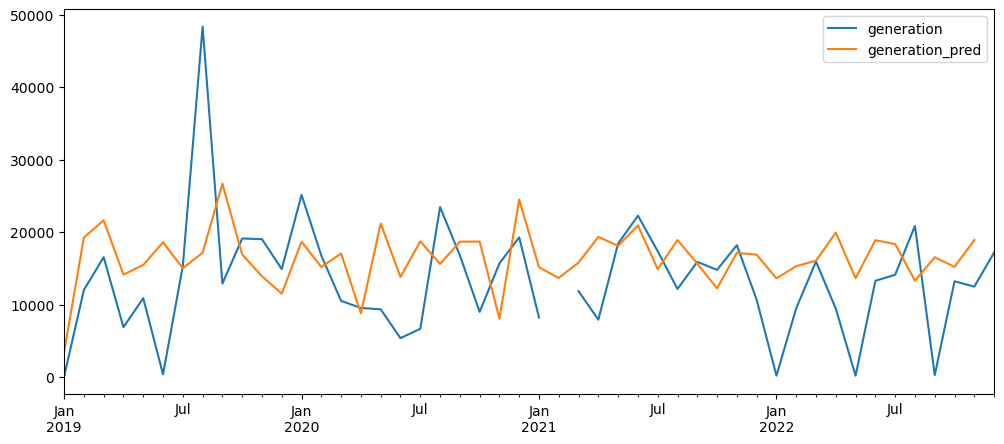

In [31]:
# Plot the chart
oth_test_vs_pred_gen.plot(figsize = (12, 5))

In [32]:
# Export the predicted data into Json format
pd.concat([test_oth, oth_predictions], axis = 1).reset_index().rename(columns = {'index': 'period'}).to_json('../static/data/predicted_others.json', orient = 'records', date_format = 'iso')

## Training Model Trial 2
---
Testing with just `fossil fuels` and adjust the number of training versus testing ratio - reducing the number of testing from about `25-26%` to `20%` (from `4 years` period or `48 months` to `3 years` or `36 months`). Keep the same number of lag based on the previous model's VAR select_order as well as same number of max iteration (`maxiter`).

consumption-for-eg-btu_pred's Root Mean Squared Error (RMSE) is: 71.10301825251989\
The mean of the test data consumption-for-eg-btu    129.805833\
Percent error: consumption-for-eg-btu    0.547764\

generation_pred's Root Mean Squared Error (RMSE) is: 7817.965074709033\
The mean of the test data generation    15085.655833\
Percent error: generation    0.518238\

In [33]:
# For fossil fuels
train_ff_2 = ff_df[['consumption-for-eg-btu', 'generation']][: 144]
test_ff_2 = ff_df[['consumption-for-eg-btu', 'generation']][144: ]

print(train_ff_2.shape, test_ff_2.shape)

(144, 2) (36, 2)


In [34]:
var_ff_model_2 = VARMAX(train_ff_2, order = (40, 0), enforce_stationarity  = True)
fit_var_ff_model_2 = var_ff_model_2.fit(maxiter = 200, disp = False)
print(fit_var_ff_model_2.summary())

                                      Statespace Model Results                                      
Dep. Variable:     ['consumption-for-eg-btu', 'generation']   No. Observations:                  144
Model:                                              VAR(40)   Log Likelihood               -1945.344
                                                + intercept   AIC                           4220.688
Date:                                      Sun, 11 Feb 2024   BIC                           4710.707
Time:                                              23:03:15   HQIC                          4419.804
Sample:                                          01-01-2008                                         
                                               - 12-01-2019                                         
Covariance Type:                                        opg                                         
Ljung-Box (L1) (Q):             0.31, 0.00   Jarque-Bera (JB):         608.13, 8.88
Prob(Q)

In [35]:
ff_n_forecast_2 = len(test_ff_2)
ff_n_forecast_2

36

In [36]:
ff_predict_2 = fit_var_ff_model_2.get_prediction(start = len(train_ff_2), end = len(train_ff_2) + ff_n_forecast_2 - 1)
ff_predictions_2 = ff_predict_2.predicted_mean

In [37]:
# Create the columns for the predicted data
ff_predictions_2.columns = ['consumption-for-eg-btu_pred', 'generation_pred']
ff_predictions_2.head()

,consumption-for-eg-btu_pred,generation_pred
2020-01-01,143.429621,15884.327597
2020-02-01,205.832469,21486.261552
2020-03-01,94.971414,11377.327940
2020-04-01,-31.243610,-2783.325447
2020-05-01,-39.191249,-3584.299206


In [38]:
# Get the Root Mean Squared Error (SMSE) for each of the columns
# For consumption
get_rt_mean_sqr_err(ff_predictions_2[['consumption-for-eg-btu_pred']], test_ff_2[['consumption-for-eg-btu']])

print()

# For generation
get_rt_mean_sqr_err(ff_predictions_2[['generation_pred']], test_ff_2[['generation']])

consumption-for-eg-btu_pred's Root Mean Squared Error (RMSE) is: 71.10301825251989
The mean of the test data consumption-for-eg-btu    129.805833
dtype: float64
Percent error: consumption-for-eg-btu    0.547764
dtype: float64

generation_pred's Root Mean Squared Error (RMSE) is: 7817.965074709033
The mean of the test data generation    15085.655833
dtype: float64
Percent error: generation    0.518238
dtype: float64


In [39]:
# Export the predicted data into Json format
pd.concat([test_ff_2, ff_predictions_2], axis = 1).reset_index().rename(columns = {'index': 'period'}).to_json('../static/data/predicted_ff_2.json', orient = 'records', date_format = 'iso')

## Training Model Trial 3
---
Testing with just `fossil fuels` and adjust the number of training versus testing ratio - further reducing the number of testing to `1 year` period or `12 months`. Use the get_var_lag_summary function to determine a new lag using the same max lag of `40`. Set the max iteration (`maxiter`) to `100`.

consumption-for-eg-btu_pred's Root Mean Squared Error (RMSE) is: 62.38733392127504\
The mean of the test data consumption-for-eg-btu    126.655\
Percent error: consumption-for-eg-btu    0.492577\

generation_pred's Root Mean Squared Error (RMSE) is: 6768.430733739779\
The mean of the test data generation    14517.44\
Percent error: generation    0.466228\

In [40]:
# For fossil fuels
train_ff_3 = ff_df[['consumption-for-eg-btu', 'generation']][: 168]
test_ff_3 = ff_df[['consumption-for-eg-btu', 'generation']][168: ]

print(train_ff_3.shape, test_ff_3.shape)

(168, 2) (12, 2)


In [41]:
get_var_lag_summary(train_ff_3, maxlags = 40)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        23.41       23.46   1.474e+10       23.43
1        22.89       23.02   8.733e+09       22.94
2        22.68      22.91*   7.103e+09       22.77
3        22.61       22.93   6.615e+09      22.74*
4        22.63       23.03   6.704e+09       22.79
5        22.62       23.11   6.639e+09       22.82
6        22.62       23.20   6.670e+09       22.86
7        22.63       23.30   6.714e+09       22.90
8        22.68       23.44   7.072e+09       22.99
9        22.57       23.42   6.364e+09       22.92
10       22.57       23.51   6.397e+09       22.96
11      22.56*       23.59  6.323e+09*       22.98
12       22.58       23.70   6.489e+09       23.04
13       22.62       23.83   6.762e+09       23.11
14       22.67       23.97   7.140e+09       23.20
15       22.71       24.10   7.466e+09       23.28
16       22.71       24.19   7.

In [42]:
var_ff_model_3 = VARMAX(train_ff_3, order = (11, 0), enforce_stationarity  = True)
fit_var_ff_model_3 = var_ff_model_3.fit(maxiter = 100, disp = False)
print(fit_var_ff_model_3.summary())

                                      Statespace Model Results                                      
Dep. Variable:     ['consumption-for-eg-btu', 'generation']   No. Observations:                  168
Model:                                              VAR(11)   Log Likelihood               -2299.833
                                                + intercept   AIC                           4697.667
Date:                                      Sun, 11 Feb 2024   BIC                           4850.741
Time:                                              23:06:20   HQIC                          4759.792
Sample:                                          01-01-2008                                         
                                               - 12-01-2021                                         
Covariance Type:                                        opg                                         
Ljung-Box (L1) (Q):             0.00, 0.08   Jarque-Bera (JB):        1263.51, 7.86
Prob(Q)

In [43]:
ff_n_forecast_3 = len(test_ff_3)
ff_n_forecast_3

12

In [44]:
ff_predict_3 = fit_var_ff_model_3.get_prediction(start = len(train_ff_3), end = len(train_ff_3) + ff_n_forecast_3 - 1)
ff_predictions_3 = ff_predict_3.predicted_mean

In [45]:
# Create the columns for the predicted data
ff_predictions_3.columns = ['consumption-for-eg-btu_pred', 'generation_pred']
ff_predictions_3.head()

,consumption-for-eg-btu_pred,generation_pred
2022-01-01,59.799016,6990.746000
2022-02-01,83.379062,9754.503224
2022-03-01,92.941331,10618.649198
2022-04-01,97.973563,11195.977050
2022-05-01,117.056681,13248.519834


In [46]:
# Get the Root Mean Squared Error (SMSE) for each of the columns
# For consumption
get_rt_mean_sqr_err(ff_predictions_3[['consumption-for-eg-btu_pred']], test_ff_3[['consumption-for-eg-btu']])

print()

# For generation
get_rt_mean_sqr_err(ff_predictions_3[['generation_pred']], test_ff_3[['generation']])

consumption-for-eg-btu_pred's Root Mean Squared Error (RMSE) is: 62.38733392127504
The mean of the test data consumption-for-eg-btu    126.655
dtype: float64
Percent error: consumption-for-eg-btu    0.492577
dtype: float64

generation_pred's Root Mean Squared Error (RMSE) is: 6768.430733739779
The mean of the test data generation    14517.44
dtype: float64
Percent error: generation    0.466228
dtype: float64


In [47]:
# Export the predicted data into Json format
pd.concat([test_oth, oth_predictions], axis = 1).reset_index().rename(columns = {'index': 'period'}).to_json('../static/data/predicted_ff_3.json', orient = 'records', date_format = 'iso')

## Linear Regression Model Trial
---
Using fossil fuels

In [13]:
import hvplot.pandas
from sklearn.linear_model import LinearRegression

In [52]:
ff_df.head()

,ash-content,consumption-for-eg-btu,consumption-uto-btu,cost-per-btu,generation,heat-content,receipts-btu,stocks,sulfur-content,total-consumption-btu
period,,,,,,,,,,
2008-01-01,3.12,281.61,10.36,7.00,28830.19,9.85,266757.42,23911.23,0.82,291.97
2008-02-01,3.03,193.27,8.91,6.69,19511.71,11.03,191351.71,17899.89,1.16,202.18
2008-03-01,3.10,313.18,8.63,7.17,31611.79,10.60,331404.22,28144.92,0.96,321.80
2008-04-01,2.40,60.49,6.19,7.92,6606.74,10.13,72365.60,6495.41,0.98,66.68
2008-05-01,3.14,216.15,6.59,8.73,22015.65,9.24,237419.53,19973.35,0.87,222.75


In [53]:
ff_lr_df = ff_df.copy()[['generation']]
ff_lr_df.head()

,generation
period,
2008-01-01,28830.19
2008-02-01,19511.71
2008-03-01,31611.79
2008-04-01,6606.74
2008-05-01,22015.65


In [54]:
ff_lr_df = ff_lr_df.reset_index()
ff_lr_df.head()

,period,generation
0,2008-01-01,28830.19
1,2008-02-01,19511.71
2,2008-03-01,31611.79
3,2008-04-01,6606.74
4,2008-05-01,22015.65


In [55]:
ff_lr_df.dtypes

period        datetime64[ns]
generation           float64
dtype: object

In [56]:
ff_lr_plot = ff_lr_df.hvplot.scatter(
    x = 'period',
    y = 'generation',
    title = 'Electric Generation from 2008 - 2022'
)
ff_lr_plot

:Scatter   [period]   (generation)

In [87]:
# Reformat period column (X) as a single 
# X = ff_lr_df['period'].dt.strftime('%Y%m').values.reshape(-1, 1)
X = ff_lr_df['period'].dt.strftime('%Y%m').astype('int').values.reshape(-1, 1)
X[:5]

array([[200801],
       [200802],
       [200803],
       [200804],
       [200805]])

In [88]:
X.shape

(180, 1)

In [92]:
# Create the target column (y)
y = ff_lr_df['generation']
y.head()

0    28830.19
1    19511.71
2    31611.79
3     6606.74
4    22015.65
Name: generation, dtype: float64

In [93]:
# Create a LR instance
lr_model = LinearRegression()

In [94]:
# Fit the data
lr_model.fit(X, y)

LinearRegression()

In [95]:
# Display the slope
print(f'Model\'s slope: {lr_model.coef_}')

Model's slope: [-2.95074407]


In [96]:
# Display the y-intercept
print(f'Model\'s y-intercept: {lr_model.intercept_}')

Model's y-intercept: 611150.8156728877


In [97]:
# Display the model's best fit line formula
print(f"Model's formula: y = {lr_model.intercept_} + {lr_model.coef_[0]}X")

Model's formula: y = 611150.8156728877 + -2.950744073629822X


In [98]:
# Display the formula to predict the generation for 12 months
print(f"Model's formula: y = {lr_model.intercept_} + {lr_model.coef_[0]} * 12")

# Predict the generation for 12 months
y_12 = lr_model.intercept_ + lr_model.coef_[0] * 7

# Display the prediction
print(f"Predicted generation for 12 months: {y_12}")

Model's formula: y = 611150.8156728877 + -2.950744073629822 * 12
Predicted generation for 12 months: 611130.1604643724


In [99]:
# Make predictions using X set
predicted_y_values = lr_model.predict(X)

In [100]:
# Create a copy of the DF
predicted_df = ff_df.copy()

# Append column for the predicted generation values
predicted_df['generation_predicted'] = predicted_y_values
predicted_df = predicted_df[['generation', 'generation_predicted']]
predicted_df = predicted_df.reset_index()

# Display
predicted_df.head()

,period,generation,generation_predicted
0,2008-01-01,28830.19,18638.454944
1,2008-02-01,19511.71,18635.504200
2,2008-03-01,31611.79,18632.553456
3,2008-04-01,6606.74,18629.602712
4,2008-05-01,22015.65,18626.651968


In [101]:
# Create a line plot of the predicted generation values
best_fit_line = predicted_df.hvplot.line(
    x = 'period',
    y = 'generation_predicted',
    color = 'red'
)
best_fit_line

:Curve   [period]   (generation_predicted)

In [102]:
predicted_df.to_json('../static/data/predicted_ff_lr.json', orient = 'records', date_format = 'iso')